In [142]:
## This is my notebook on Energy Consumption Analysis under time series data.
!pip install xgboost


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
colors = sns.color_palette()
plt.style.use('fivethirtyeight')

In [85]:
## load the dataset

data = pd.read_csv('C:/Users/hites/Downloads/AEP_hourly.csv/AEP_hourly.csv')
data.set_index('Datetime', inplace=True)
data.index = pd.to_datetime(data.index)


In [116]:
data

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


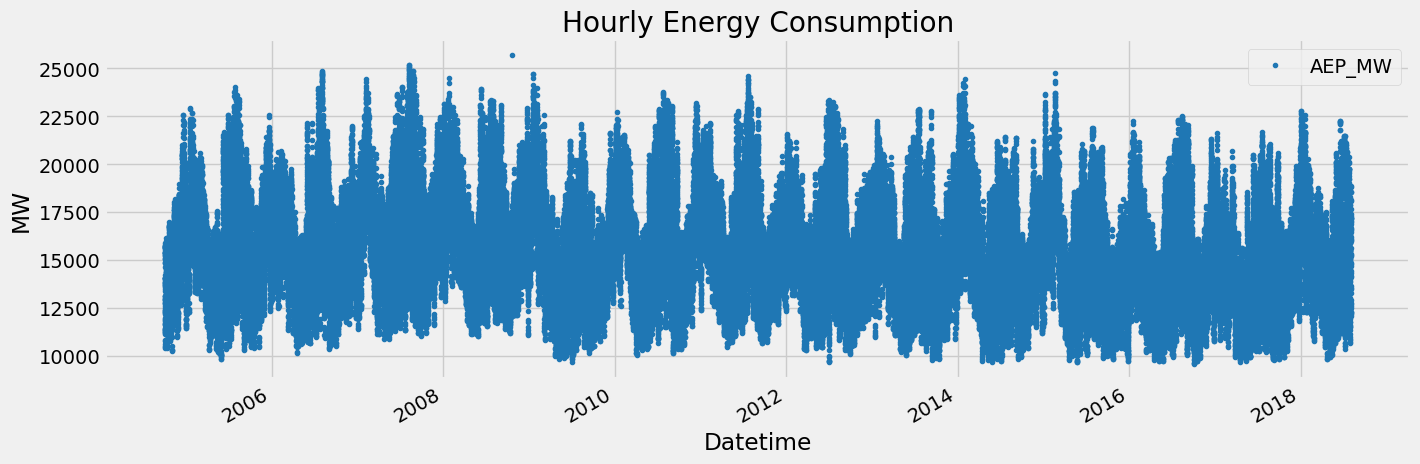

In [96]:
data.plot(style='.',
        figsize=(15, 5),
        color=colors[0])
plt.title('Hourly Energy Consumption')
plt.ylabel('MW')
plt.show()

## Train/test split

In [100]:
train = data.loc[data.index < '01-01-2015']
test = data.loc[data.index >= '01-01-2015']

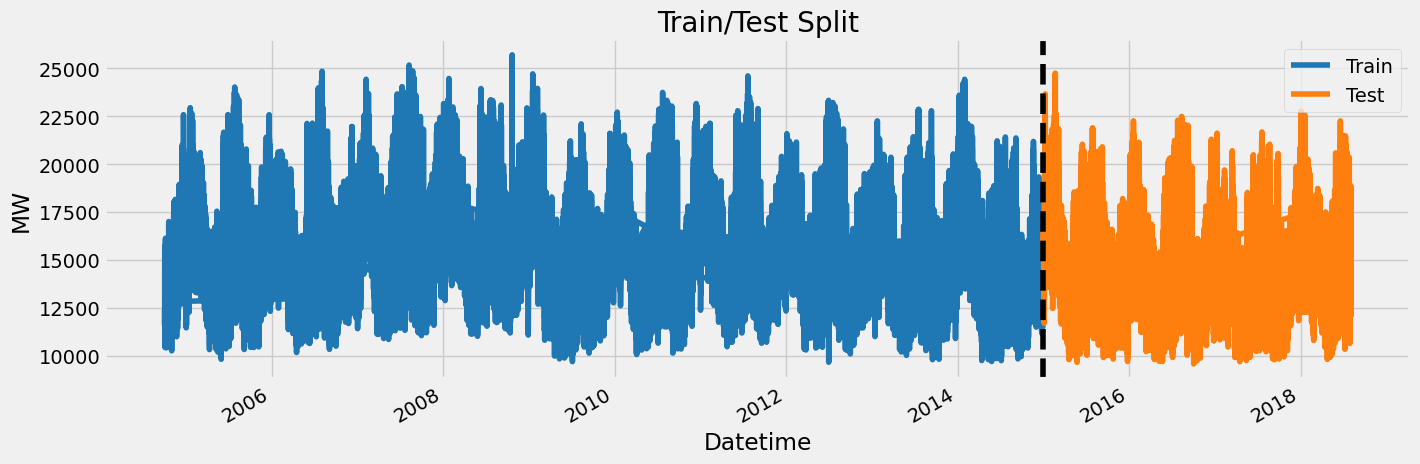

In [107]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Data', color=colors[0])
test.plot(ax=ax, label='Test Data', color=colors[1])
plt.title('Train/Test Split')
plt.ylabel('MW')
ax.axvline(test.index[0], color='k', linestyle='--')
plt.legend(['Train', 'Test'])
plt.show()


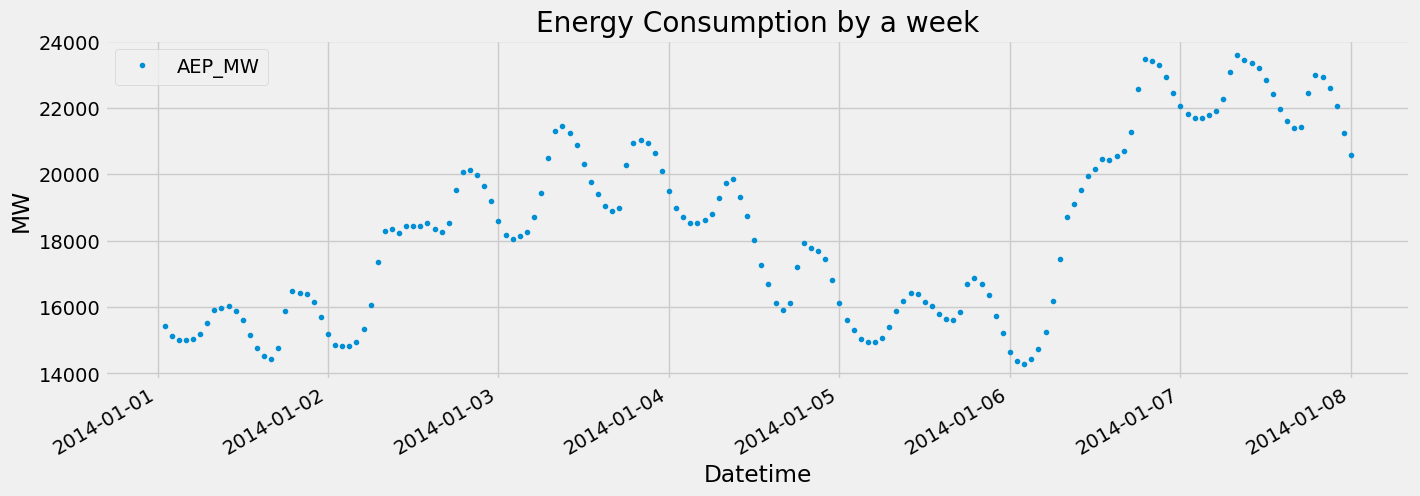

In [121]:
data.loc[ (data.index > '01-01-2014') & (data.index <= '01-08-2014') ].plot(style='.', figsize=(15, 5))
plt.title('Energy Consumption by a week')
plt.ylabel('MW')
plt.show()

## Observation and further processing. 

Here we see varying of the energy consumption based on the times of the day like in the morning the energy consumption is moderate, low in the afternoon and high in the evening times.   
further we can see that on weekends the consumption of energy is high. 

#### Proceedance
We will now proceed by making more meaning full features extraced from the datetime format.

In [135]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df.loc[:,'hour'] = df.index.hour
    df.loc[:,'dayofweek'] = df.index.dayofweek
    df.loc[:,'quarter'] = df.index.quarter
    df.loc[:,'month'] = df.index.month
    df.loc[:,'year'] = df.index.year
    df.loc[:,'dayofyear'] = df.index.dayofyear
    df.loc[:,'dayofmonth'] = df.index.day
    df.loc[:,'weekofyear'] = df.index.isocalendar().week
    return df

create_features(data);
data

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366,31,53
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366,31,53
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366,31,53
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366,31,53
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366,31,53
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,21089.0,20,0,1,1,2018,1,1,1
2018-01-01 21:00:00,20999.0,21,0,1,1,2018,1,1,1
2018-01-01 22:00:00,20820.0,22,0,1,1,2018,1,1,1


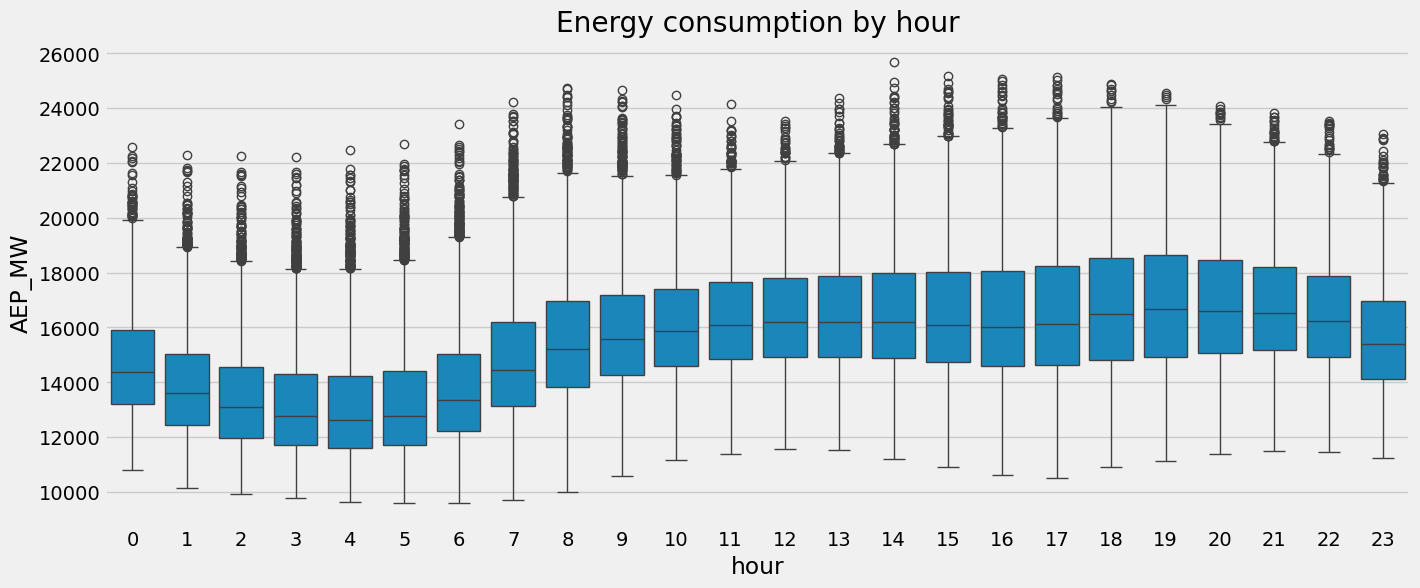

In [136]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(data=data, x='hour', y='AEP_MW')
ax.set_title('Energy consumption by hour')
plt.show()

This plot again shows us the peek hours of when the energy consumption is high. idealy in the evening from 17 to 21

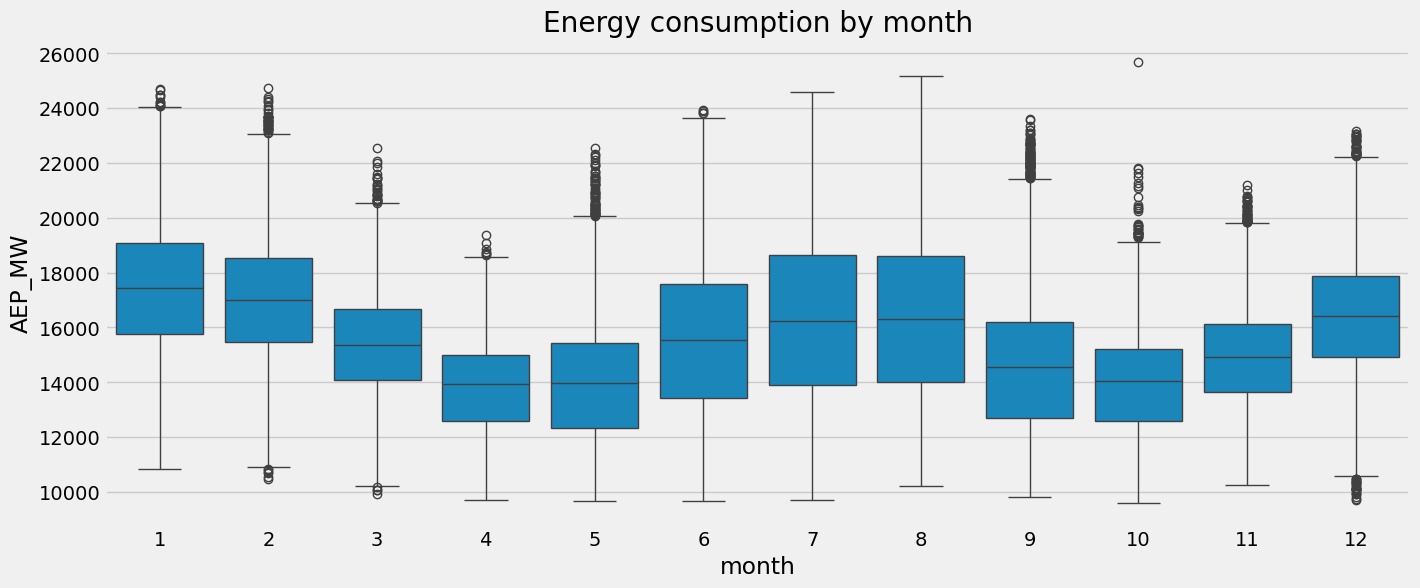

In [137]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(data=data, x='month', y='AEP_MW')
ax.set_title('Energy consumption by month')
plt.show()

This plot again shows us the seasonal trend of usage of power. i.e, during summer and winter the power consumption is generally high cause of usage of A/C and Heaters

## Now we proceed to create our model

In [138]:
train = create_features(train)
test = create_features(test)

Features=['hour', 'dayofweek', 'quarter', 'month', 'year','weekofyear']
Target=['AEP_MW']

X_train = train[Features]
y_train = train[Target]
X_test = test[Features]
y_test = test[Target]

In [171]:
reg = xgb.XGBRegressor(
    n_estimators=10000,
    learning_rate=0.01,
    gamma=5,
    min_child_weight=8,
    max_depth=4,
    early_stopping_rounds=50,
    objective='reg:linear',
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

reg.fit(X_train, y_train, 
       eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
         )


[0]	validation_0-rmse:2567.28720	validation_1-rmse:2679.55253


c:\Users\hites\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [23:51:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:1887.70925	validation_1-rmse:2095.51227
[200]	validation_0-rmse:1611.04304	validation_1-rmse:1872.45403
[300]	validation_0-rmse:1470.81437	validation_1-rmse:1763.20104
[400]	validation_0-rmse:1384.10394	validation_1-rmse:1702.22779
[500]	validation_0-rmse:1327.56214	validation_1-rmse:1671.06571
[600]	validation_0-rmse:1289.30419	validation_1-rmse:1658.20059
[700]	validation_0-rmse:1262.13912	validation_1-rmse:1653.04829
[800]	validation_0-rmse:1242.42884	validation_1-rmse:1651.01068
[832]	validation_0-rmse:1236.37606	validation_1-rmse:1650.51829


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=5, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=8, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=-1, num_parallel_tree=None, ...)

After all sorts of parameter tuning , i could manage to get the rmse down to 1650 MW. now lets try some other methods to improve our model. 

Now we try to add more features to the dataset and then try training again. 

## Lagged feature
we will now try to implement thee lagged features for the dataset from :
1. The last 1, 2, and 3 hours (Short-term context).
2. The same hour yesterday (24 hours ago, capturing daily seasonality).
3. The same hour one week ago (168 hours ago, capturing weekly seasonality).

In [176]:
def create_lagged_features(data):
    """
    This function creates lagged features for the dataset
    """    
    data['lag_1'] = data['AEP_MW'].shift(1)
    data['lag_2'] = data['AEP_MW'].shift(2)
    data['lag_3'] = data['AEP_MW'].shift(3)
    data['lag_24'] = data['AEP_MW'].shift(24)
    data['lag_168'] = data['AEP_MW'].shift(24 * 7)
    return data

data_Lagged = create_lagged_features(data)

Now we rerun the train test split

In [177]:
train = data_Lagged.loc[data_Lagged.index < '01-01-2015']
test = data_Lagged.loc[data_Lagged.index >= '01-01-2015']

train = create_features(train)
test = create_features(test)

Features=['hour', 'dayofweek', 'quarter', 'month', 'year','weekofyear','lag_1','lag_2','lag_3','lag_24','lag_168']
Target=['AEP_MW']

X_train = train[Features]
y_train = train[Target]
X_test = test[Features]
y_test = test[Target]

In [179]:
reg = xgb.XGBRegressor(
    n_estimators=10000,
    learning_rate=0.01,
    gamma=5,
    min_child_weight=8,
    max_depth=4,
    early_stopping_rounds=50,
    objective='reg:linear',
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

reg.fit(X_train, y_train, 
       eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
         )

[0]	validation_0-rmse:2551.46133	validation_1-rmse:2661.90975


c:\Users\hites\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [00:04:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:1101.75205	validation_1-rmse:1156.10232
[200]	validation_0-rmse:614.58328	validation_1-rmse:638.60009
[300]	validation_0-rmse:465.51582	validation_1-rmse:475.62301
[400]	validation_0-rmse:412.47587	validation_1-rmse:419.91682
[500]	validation_0-rmse:387.99437	validation_1-rmse:395.43569
[600]	validation_0-rmse:373.18918	validation_1-rmse:381.83864
[700]	validation_0-rmse:360.54580	validation_1-rmse:370.43914
[800]	validation_0-rmse:350.49300	validation_1-rmse:361.06933
[900]	validation_0-rmse:342.74462	validation_1-rmse:353.67135
[1000]	validation_0-rmse:335.81302	validation_1-rmse:347.00363
[1100]	validation_0-rmse:329.77574	validation_1-rmse:341.43869
[1200]	validation_0-rmse:324.45726	validation_1-rmse:336.26185
[1300]	validation_0-rmse:319.22948	validation_1-rmse:331.41201
[1400]	validation_0-rmse:315.12380	validation_1-rmse:327.61000
[1500]	validation_0-rmse:311.27729	validation_1-rmse:324.12378
[1600]	validation_0-rmse:307.08276	validation_1-rmse:320.38934

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=5, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=8, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [181]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = reg.predict(X_test)

# 1. Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# 2. Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# 3. R-Squared (R2)
r2 = r2_score(y_test, y_pred)

print(f"R-squared (R2): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} MW")
print(f"Mean Absolute Error (MAE): {mae:.2f} MW")

R-squared (R2): 0.9901
Root Mean Squared Error (RMSE): 250.46 MW
Mean Absolute Error (MAE): 151.37 MW


## BOOYAH !!!
An exceptional performance of my model when the lagged features got introduced. 

## Final Observations. 
1. Our RMSE ended up at 250 , which is exceptionally good in the real world scenario. 
2. Our tree count increased to 9999 but the trade off is worth the result. 
3. We attained 99.01% of accuracy on the unseen data. 
4. This model will perform good in the real world scenario